<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords 
from sklearn.model_selection import GridSearchCV
import warnings
import nltk
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data['toxic'].unique()

array([0, 1])

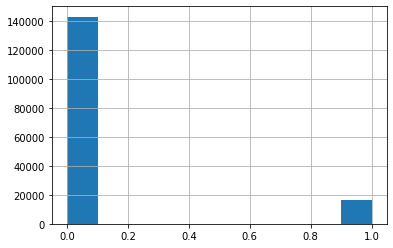

In [6]:
data['toxic'].hist();

In [7]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
lemmatizer = WordNetLemmatizer()


<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Привет Марат!.
Написал функцию, котрая преобразует POS-теги из формата nltk.pos_tag в формат, который понимает WordNetLemmatizer для правильной лемматизации.</div>

In [10]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
def predproc(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized)


data['predproc'] = data['text'].apply(predproc)

In [12]:
data.head()

,text,toxic,predproc
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


In [13]:
df = data.copy()
y = df['toxic']
df = df.drop(['toxic'], axis = 1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, stratify=y, random_state=42)

In [15]:
print('Train data shape:', x_train.shape, y_train.shape)
print('Test data shape:', x_test.shape, y_test.shape)

Train data shape: (111504, 2) (111504,)
Test data shape: (47788, 2) (47788,)


Данные были предварительно обработаны: удалены лишние символы, проведена лемматизация и преобразование в векторное представление.

## Обучение

In [16]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(x_train['predproc'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid


In [17]:
lr_mod = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.775700609170109
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [18]:
dtc_mod = training(DecisionTreeClassifier(random_state=42), {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [2, 4, 6]})

Лучший результат: 0.5532851416422666
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6}


На тренировочной выборке лучший результат у LogisticRegression, поэтому протестируем её на тестовой выборке

In [19]:
res = f1_score(y_test, lr_mod.predict(x_test['predproc']))

In [20]:
print("Результат LogisticRegression", res)

Результат LogisticRegression 0.7795438838977193


## Выводы

В ходе работы данные были очищены от лишних символов, лемматизированы и преобразованы в векторный формат. Для решения задачи классификации были протестированы три модели: Logistic Regression, Decision Tree, с подбором гиперпараметров для каждой. Лучшую точность на обучающей выборке показала Logistic Regression, и она же дала самый высокий F1-результат на тестовой выборке. Это говорит о том, что именно эта модель лучше всего справилась с поставленной задачей.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны